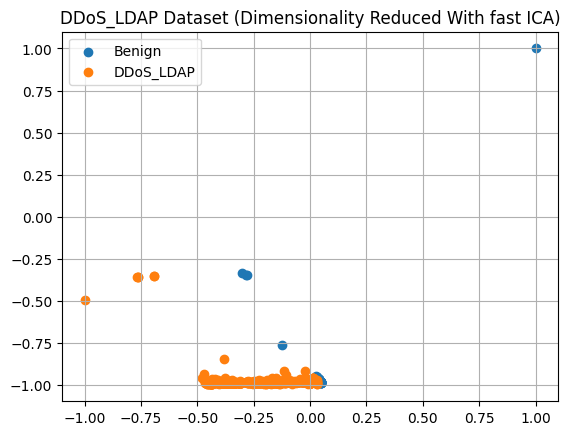

Accuracy: 0.8399122807017544
Precision: 0.8909446104343829
Recall: 0.8399122807017544
F1 Score: 0.8440017587525828


In [4]:
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.circuit.library import ZZFeatureMap
#from qiskit.providers.aer import StatevectorSimulator
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.decomposition
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Read the dataset
def DDoS_LDAP(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'BENIGN', r'DDoS_LDAP']

    data = pd.read_csv('ddos_ldap.csv')
    
    # Standardize the dataset
    x = StandardScaler().fit_transform(np.array(data.drop(columns=['Label'])))
    y = np.array(data['Label'].astype('category').cat.codes.astype(int))
    
    # Split the dataset into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=109)
    
    # Reduce the dimensions of the dataset
    ICA = sklearn.decomposition.FastICA(n_components=n, random_state=15).fit(X_train)
    X_train = ICA.transform(X_train)
    X_test = ICA.transform(X_test)
    
    # Normalize the dataset
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_test[Y_test == k, :])[:test_size] for k, key in enumerate(class_labels)}

     # Plot the dataset after reducing its dimensions  
    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]
            label = 'DDoS_LDAP' if k == 1 else 'Benign'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("DDoS_LDAP Dataset (Dimensionality Reduced With fast ICA)")
        plt.legend()
        plt.grid()
        plt.show()

    return X_train, training_input, test_input, class_labels


def split_dataset_to_data_and_labels(data):
    datapoints = []
    labels = []
    class_to_label = {}
    for label, points in data.items():
        datapoints.extend(points)
        labels.extend([label] * len(points))
        class_to_label[label] = label
    return datapoints, labels, class_to_label

training_dataset_size = 4500
testing_dataset_size = 500

sample_Total, training_input, test_input, class_labels = DDoS_LDAP(
    training_dataset_size, testing_dataset_size, 2)

# Convert the data to the required format for classical SVM
datapoints, labels, class_to_label = split_dataset_to_data_and_labels(
    test_input)

# Prepare the quantum feature map
feature_map = ZZFeatureMap(feature_dimension=2, reps=2)

# Create classical SVM classifier
qsvm = SVC(kernel='linear', probability=True, random_state=0)

X_train_q = []
for params in training_input[class_labels[0]]:
    qc = feature_map.assign_parameters(params)
    X_train_q.append(qc)

for params in training_input[class_labels[1]]:
    qc = feature_map.assign_parameters(params)
    X_train_q.append(qc)

X_test_q = []
for params in datapoints:
    qc = feature_map.assign_parameters(params)
    X_test_q.append(qc)

# Transpile the circuits to match the simulator backend
backend = Aer.get_backend('statevector_simulator')
X_train_q = transpile(X_train_q, backend)
X_test_q = transpile(X_test_q, backend)

# Execute the circuits on the simulator backend and store the statevector results
X_train_q_statevecs = []
for qc in X_train_q:
    result = backend.run(qc).result()
    statevec = result.get_statevector()
    X_train_q_statevecs.append(statevec)

X_test_q_statevecs = []
for qc in X_test_q:
    result = backend.run(qc).result()
    statevec = result.get_statevector()
    X_test_q_statevecs.append(statevec)

# Convert the statevectors to feature vectors
X_train_q = np.array([np.real(vec) for vec in X_train_q_statevecs])
X_test_q = np.array([np.real(vec) for vec in X_test_q_statevecs])

# Define Y_train
Y_train = np.array([0]*len(training_input[class_labels[0]]) + [1]*len(training_input[class_labels[1]]))

qsvm.fit(X_train_q, Y_train)

# Run the SVM classifier for classification
predicted_labels_int = qsvm.predict(X_test_q)

# Convert predicted labels to string format
predicted_labels = [class_labels[label] for label in predicted_labels_int]

# Calculate classification metrics
accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels, average='weighted')
recall = recall_score(labels, predicted_labels, average='weighted')
f1 = f1_score(labels, predicted_labels, average='weighted')

# print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)